In [3]:
# !pip3 install seaborn

In [5]:
!pip3 install git+ssh://git@github.com/Holmusk/neuroblu_postgres.git@v1.0.2#egg=neuroblu_postgres
!pip3 install psycopg2-binary
!pip3 install statsmodels
!pip3 install git+https://github.com/lsmoriginal/Tacos.git#egg=Tacos

Defaulting to user installation because normal site-packages is not writeable
  Cloning ssh://****@github.com/Holmusk/neuroblu_postgres.git (to revision v1.0.2) to /tmp/pip-install-o5ncl79w/neuroblu-postgres_94561d8641ae449fb1f37d4d54ffbc45
  Running command git clone --filter=blob:none --quiet 'ssh://****@github.com/Holmusk/neuroblu_postgres.git' /tmp/pip-install-o5ncl79w/neuroblu-postgres_94561d8641ae449fb1f37d4d54ffbc45
  Running command git checkout -q 9aab64d14ea0c60821a42d068c863855cc85c8fc
  Resolved ssh://****@github.com/Holmusk/neuroblu_postgres.git to commit 9aab64d14ea0c60821a42d068c863855cc85c8fc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neuroblu_postgres: filename=neuroblu_postgres-1.0.2-py2.py3-none-any.whl size=37464 sha256=4781394b5b3cec1703af0d501eef79654e4b657d1f0f15d2d6f39475db87e347
  Stored in directory: /tmp/pip-ephem-wheel-cache-j0mjqc2m/wheels/03/a8/f

In [1]:
import pandas as pd
import seaborn as sns

from itertools import chain
from pathlib import Path

import re

import os
os.environ["DB_PATH"]='../../db.json'
from neuroblu_postgres.databaseIO import pgIO

# Distribution of the current tokens

In [2]:
# about 1min for 11Million rows
tokenCountFrSourceDbDfPath = Path('tokenCountFrSourceDbDf.csv')

if not tokenCountFrSourceDbDfPath.exists():
    tokenCountFrSourceDb = pgIO.getDataIterator(
        query=f'''
        SELECT 
            sentences.database, 
            sentences.sentence, 
            sentences.n_token
        FROM v1_nlp.sentences
        ; 
        ''',
        dbName='NLP_CDM',
        chunks=10000,
    )
    alldata = chain(*tokenCountFrSourceDb)

    tokenCountFrSourceDbDf = pd.DataFrame(
        alldata,
        columns=['database','sentence', 'n_token'],
    )
    tokenCountFrSourceDbDf.to_csv(
        tokenCountFrSourceDbDfPath,
        index=False
    )
else:
    tokenCountFrSourceDbDf = pd.read_csv(
        tokenCountFrSourceDbDfPath,
    )

In [3]:
tokenCountFrSourceDbDf.shape
# 11 Million sentences

(11535536, 3)

<AxesSubplot:xlabel='n_token', ylabel='Count'>

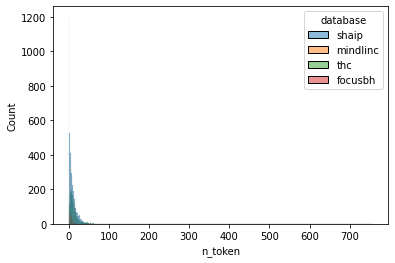

In [4]:
sns.histplot(
    data=tokenCountFrSourceDbDf.sample(10000),
    x='n_token',
    hue='database',
)

<AxesSubplot:xlabel='database', ylabel='n_token'>

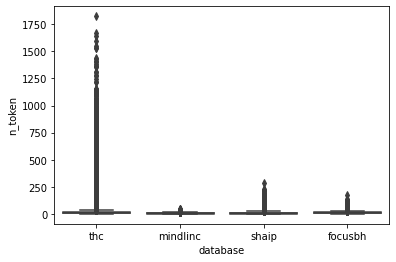

In [33]:
sns.boxplot(
    data=tokenCountFrSourceDbDf,
    y='n_token',
    x='database'
)

Harris center is the worst in terms of sentence tokenizing.

In [9]:
shaipLongSent = tokenCountFrSourceDbDf[(tokenCountFrSourceDbDf.database=='shaip') & (tokenCountFrSourceDbDf.n_token >=150)]
shaipLongSent.head()

,database,sentence,n_token
3825824,shaip,"upon challenging her, it takes a significant a...",211
3897103,shaip,"since he had already paid his money, he to thi...",197
3967719,shaip,the patient was last discharged range of motio...,158
3967763,shaip,he has to maintain a gpa of 3.2 to stay in his...,153
4852292,shaip,i am going to continue the same medications at...,164


# Why does thc has such ridiculously long sentences

* \\n next line chars 
* \r\n repetitions -> most probably point forms
* ____________ underscores  

In [10]:
sampleLongText=tokenCountFrSourceDbDf[(tokenCountFrSourceDbDf.database=='thc') & (tokenCountFrSourceDbDf.n_token >=1750)].sentence[2274188]
sampleLongText[:2500]

'INPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine follow up appointment was conducted via telephone\r\nthe client consented to a telephone appointment\r\nhe reports taking his medication daily as prescribed\r\nall medication is working well\r\nhis mood is stable\r\nhe denies mood swings and depression\r\nhe denies AVH, delusions and paranoia\r\nappetite and sleep pattern are intact\r\nenergy level and motivation are good\r\nthe current medication regimen is effective and there are no side effects\r\nhe denies SI/HI or any thought of harm to self or others\r\n\r\nhe has a transfer appointment scheduled for [DATE_5]\r\nhe has requested to begin therapy and counseling \r\nhe will begin therapy once transferred out of New START, as New START does not provide therapy\r\nhe is aware of this plan and agrees\r\n\r\n______________________________________________________________________________________\r\nINPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine fo

In [1]:
# !pip3 install spacy==3.2.4
# !pip3 install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_scibert-0.5.0.tar.gz
!python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_sm

/usr/bin/python: No module named spacy
/usr/bin/python: No module named spacy


In [2]:

import spacy
nlp=spacy.load("en_core_sci_scibert")
doc = nlp("input text")
cleaned_data=list(item.text for item in doc.sents)

In [16]:
# breaking a long sentences takes 11secs
doc = nlp(sampleLongText)
cleaned_data_en_core_sci_scibert=list(item.text for item in doc.sents)

In [17]:
re.sub("_{3,}", ' \n ', sampleLongText)

'INPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine follow up appointment was conducted via telephone\r\nthe client consented to a telephone appointment\r\nhe reports taking his medication daily as prescribed\r\nall medication is working well\r\nhis mood is stable\r\nhe denies mood swings and depression\r\nhe denies AVH, delusions and paranoia\r\nappetite and sleep pattern are intact\r\nenergy level and motivation are good\r\nthe current medication regimen is effective and there are no side effects\r\nhe denies SI/HI or any thought of harm to self or others\r\n\r\nhe has a transfer appointment scheduled for [DATE_5]\r\nhe has requested to begin therapy and counseling \r\nhe will begin therapy once transferred out of New START, as New START does not provide therapy\r\nhe is aware of this plan and agrees\r\n\r\n \n \r\nINPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today\'s routine follow up appointment was conducted via telephone\r\nthe client consented to a telep

In [18]:
doc = nlp(re.sub("_{3,}", ' \n ', sampleLongText))
cleaned_data_en_core_sci_scibert_removed_us__=list(item.text for item in doc.sents)

Using web_trf

In [ ]:
en_core_web_trf = spacy.load("en_core_web_trf")

In [ ]:
doc = en_core_web_trf(sampleLongText)
cleaned_data_en_core_web_trf=list(item.text for item in doc.sents)

In [ ]:
en_core_web_sm = spacy.load("en_core_web_sm")

In [ ]:
doc = en_core_web_sm(sampleLongText)
cleaned_data_en_core_web_sm=list(item.text for item in doc.sents)

## View other long notes

In [12]:
sampleLongTextSamples=tokenCountFrSourceDbDf[(tokenCountFrSourceDbDf.database=='thc') & (tokenCountFrSourceDbDf.n_token >=1000)]
sampleLongTextSamples.head()

,database,sentence,n_token
1381267,thc,PT has been doing ok most days; PT has been mo...,1104
1666541,thc,"36 yr old AAM , living with his son's mother a...",1014
1673296,thc,Does go shopping and out with a friend once a ...,1096
1742450,thc,"""; \r\nPT states she is sleeping ok and that s...",1037
1848235,thc,Does admit she is having a slight headache for...,1033


In [19]:
longSample2='''======================================================================================PT is here as she has to change meds- Invega unavialable through PAP now; PT is anxiuos as she feels she is significantly calmer, with much less racing thoughts and more stable mood since starting Invegs; Pt is sleeping well; IS willing to make change in meds and try Risperdal; ======================================================================================PT states that she has been doing ok, but has not been sleeping well sleep is always disrupted; PT has been doing wotk PT as peer speicalist is enjoying it; STill very anxiuos when she has to speak in court before judge- in accordance with her position; Still having hives; PT feels she is able to think more clearly, thoughts racing has decreased; PAranoia is improved; ====================================================================================PT states she is doing much better; PT has been happy that her mood is even and she is not gaining weight; PT denies any racing thoughts; PT able to focus and concentrate at work; Is still having some paranoid thoughts and some disrupted sleep; PT much less anxiuos speaking in front of crowds with the use of propranolol and taking it once a day; DID have problems decreasing Geodon " i had bone pain all over my body";  working on getting drivers license and states " i have a car waiting for me"; ======================================================================================PT cam ein early as she found that hs eis not doing well with her mood; Feels trileptal did help with preventing cravings to use/drink; Hoever, she is having a lot of racing thoughts, unable to focus or concentrate, even on conversations; PT also waking up after 5//6 hours of sleep and is wide awake; PT with increased anxiety and broke out in hives several times when speaking in front of crowds; Very happy wto be work in Courts wih "reunifcation" court as mentor to mothers with infants and toddlers; IS teaching one class a week and is heading PAC as well; PT would like to have higher positions, but is doing well with current work; IS working out and losing weight=====================================================================================PT states she has been feeling ok, but not going to calsses, due to finishing community services; PT struggling with focusing on math ; PT sees no benefit from topomax; PT is staying sober; PT is sleeping well; All her warrants will be dropped; CPS is closed her case; PT sleeping well at night; Paranoid often about her baby and her getting hurt; PT very scared about her ex coming out of jail and hurting her as he has writted letters to her, trying to contact through others; PT has protective order;  wil start therapy soon; PT is working with [NAME_4] as peer advocate group vice president; Still feel this is the best she has done in long time; Sober from MEth for 11 months now; =====================================================================================PT seen via telepyschPT states she had been very paranoid for 1 week-  aboutt 3 weeks ago; She was very anxiuos and scared on the train, worried she would be attacked; PT also got scared at movise therater, thinking someone was going to shoot her; Thsi has since subsisded, but pt unaware what triggered this new experience; PT does feel cogentin has helped with side effects a lot; ALso, states she is no longer angry and is much calmer  and is happier; "this is the best i have been in a long time"; PT feels meds wear off at 5pm and she becomes irritable, but if she takes at that time, then she becomes sedated quickly and sleeps by 7 pm- this makes ot difficult for her to get through evening with 4 years old; ====================================================================================PT states she is still easily distracted, goes off topic, still thoughts racing and jumping around; pt still on edge, tense , chest heaviness; feels atarax is not helpful; PT did get  4 yr old dtr back and got  flex funds for apartment;  PT is much calmer and far less angry on medications; PT is in celebrate recovery, attending school for GED; Happy to having  dtr back; PT doing ok with visitations with ex; Doing family therapy - with ex; not doing trauma therapy anymore and would like to start here; ===============================================================================PT has been doing better; PT applied for a job through Salvvation army- hoping to get the desk job; PT is doing trauma counseling; PT finds that she is anxiuos and easily agitated; sleep is good; many relationship issues with mother who hs custody of her child; eating excessively and gaining weight; plans to join a gym; asking about flex funding; Staying clean and sober; pt not returning to boyfriend due to issues with his parents; ====================================================================================PT has been in treatment off and on since 18 yrs; PT then was on no meds for some time; Then , pt was in TDC - was tried on variuos meds from 2008- 2016; PT has PT states she is "ready to accept the diagnosis of bipolar d/o"; PT states CPS became involved when mother of fiancee' called on pt and husband for drug use; PT has been happy that family therapy through courts; PT  also doing truama therapy - longest sobriety was 3 years 2008-2011; PT did also in 2014- 2015- was in AA and very involved in Church ;PT states during 3 years- was working 40 hours, regular;  PT always feels her thoughts are jumping around to 20 different things at once; Was able to work ok and focus- was working manager, top position ; and able to manage this; PT has h/o impulsive behaviors- mostly when she was using; When younger was selling drugs, selling guns- was in bad neighborhood- this was around; switchboard operator - for many years; PT still has had nightmares off and on - about her ex- he is now in prison- for assualt on her; PT has been through periods of depression, sadness, crying spells, hoplessness, guilt that was ongoing for weeks; PT now feels she is on the best meds for her and "love the topomax"; PT feels she has had "severe reactions" to many medications in the past and due to poor experience stopped all meds for years; "now i need to get my life together";'''
doc = nlp(re.sub("_{3,}", ' \n ', sampleLongText))
for i in list(item.text for item in doc.sents):
    print(i)
    print('=========XXXXXXXXXX===========')

INPERSON VISIT NOT AVAILBLE FOR REASON OF Covid 19, today's routine follow up appointment was conducted via telephone

=========XXXXXXXXXX===========
the client consented to a telephone appointment
=========XXXXXXXXXX===========

he reports taking his medication daily as prescribed
all medication is working well

=========XXXXXXXXXX===========
his mood is stable
=========XXXXXXXXXX===========

he denies mood swings and depression
he denies AVH, delusions and paranoia
=========XXXXXXXXXX===========

appetite and sleep pattern are intact
=========XXXXXXXXXX===========

energy level and motivation are good
the current medication regimen is effective and there are no side effects
=========XXXXXXXXXX===========

he denies SI/HI or any thought of harm to self or others
=========XXXXXXXXXX===========


he has a transfer appointment scheduled for [DATE_5]
he has requested to begin therapy and counseling 
he will begin therapy once transferred out of New START, as New START does not provide the

## using NLTK

In [3]:

from nltk.tokenize import sent_tokenize
cleaned_data=sent_tokenize("I am speaking to Dr.Drak ramoray. Is he here today? ")
cleaned_data

['I am speaking to Dr.Drak ramoray.', 'Is he here today?']

# Download the notes

In [4]:
# about 1min for 11Million rows
notesTableDfPath = Path('notesTable.csv')

if not notesTableDfPath.exists():
    notesTable = pgIO.getDataIterator(
        query=f'''
        SELECT 
            notes.patient_id, 
            notes.patient_encounter_id, 
            notes.database,
            notes.note
        FROM v1_nlp.notes
        WHERE notes.database='thc'
        ; 
        ''',
        dbName='NLP_CDM',
        chunks=10000,
    )
    alldata = chain(*notesTable)

    notesTableDf = pd.DataFrame(
        alldata,
        columns=['patient_id',
                 'patient_encounter_id', 
                 'database',
                 'note', 
                 ],
    )
    notesTableDf.to_csv(
        notesTableDfPath,
        index=False
    )
else:
    notesTableDf = pd.read_csv(
        notesTableDfPath,
    )

In [5]:
notesTableDf['notesCleanned'] = notesTableDf.note.str.replace("_{3,}", ' \n ')
notesTableDf

The default value of regex will change from True to False in a future version.


,patient_id,patient_encounter_id,database,note,notesCleanned
0,thc_2327090027,thc_6920877,thc,"1700:\nPsychotic sx, Depressive sx, PTSD, Irri...","1700:\nPsychotic sx, Depressive sx, PTSD, Irri..."
1,thc_2327280027,thc_10769310,thc,1700:\npoor sleep pattern\r\nunemployment and ...,1700:\npoor sleep pattern\r\nunemployment and ...
2,thc_2327820027,thc_10841322,thc,1802:\nThe Illuniati are still bothering.\n\n1...,1802:\nThe Illuniati are still bothering.\n\n1...
3,thc_2327860027,thc_10272285,thc,1802:\nSocial security reported that I needed ...,1802:\nSocial security reported that I needed ...
4,thc_2327950027,thc_2316981,thc,"10133:\n[DATE_13] CMP wnl; Lipid wnl; CBC-""an...","10133:\n[DATE_13] CMP wnl; Lipid wnl; CBC-""an..."
...,...,...,...,...,...
79518,thc_998970027,thc_5104896,thc,10147:\nhypertension\r\nhigh cholesterol--star...,10147:\nhypertension\r\nhigh cholesterol--star...
79519,thc_998980027,thc_1644181,thc,3350:\nstable at baseline functioning\n\n24876...,3350:\nstable at baseline functioning\n\n24876...
79520,thc_999050027,thc_10849990,thc,"1700:\nDepression, anxiety, insomnia, non enga...","1700:\nDepression, anxiety, insomnia, non enga..."
79521,thc_999140027,thc_4331871,thc,1700:\nPsychosis/mood d/o - appears to be at c...,1700:\nPsychosis/mood d/o - appears to be at c...


In [ ]:
!pip3 install tqdm
!pip3 install ipywidgets

In [8]:
# use nltk for first layer
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [9]:
notesTableDf['nltkCleanned']=notesTableDf.notesCleanned.progress_apply(lambda sent: sent_tokenize(sent))

  0%|          | 0/79523 [00:00<?, ?it/s]

In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
from Tacos.parallelWrap import TaskLogic, ParallelWorker

class SentenceTokenising(TaskLogic):
    
    def __init__(self, ) -> None:
        super().__init__()
        self.nlp=spacy.load("en_core_sci_scibert")
    
    def workSingleTask(self, task:str):
        doc = self.nlp(task)
        cleaned_data=list(item.text for item in doc.sents)
        return cleaned_data

In [7]:
process = ParallelWorker(taskLogic = SentenceTokenising,
                             taskList= notesTableDf.notesCleanned.tolist()[:10],
                             processes = 6,
                             chunks = 8,
                             minInterval = 1)
process.run()
results=process.getResults()

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 